## Начало 

Проверим точность MobileNet V2.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input
import matplotlib.pyplot as plt
import numpy as np
import pickle
import methods

#from keras.callbacks import ModelCheckpoint

Зададим место, где лежат файлы.

In [2]:
DATA_FOLDER = "data/zakladki"
CATEGORY_1 = "nezakl"
CATEGORY_2 = "zakl"

## Взглянем на данные 

nezakl training data length:  3101
zakl training data length:  3101
nezakl validation data length:  500
zakl validation data length:  500
nezakl test data length:  500
zakl test data length:  500


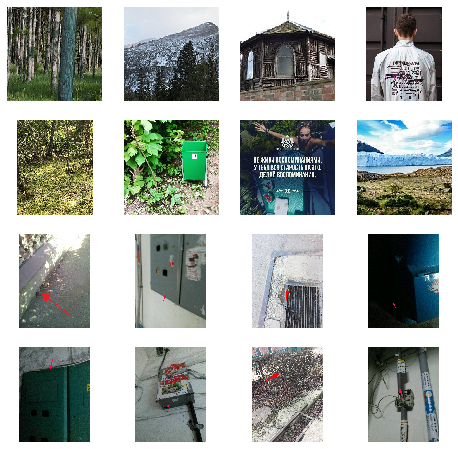

In [3]:
methods.visualize_data(DATA_FOLDER, CATEGORY_1, CATEGORY_2)

## Подготовим данные

In [49]:
image_size = 150
batch_size = 32

train_datagen = ImageDataGenerator(rescale = 1/255)
validation_datagen = ImageDataGenerator(rescale = 1/255)


train_generator = train_datagen.flow_from_directory(
        DATA_FOLDER + '/train',
        target_size = (image_size, image_size),
        batch_size = batch_size,
        class_mode = 'binary'
)

validation_generator = validation_datagen.flow_from_directory(
        DATA_FOLDER + '/validation',
        target_size = (image_size, image_size),
        batch_size = batch_size,
        class_mode = 'binary'
)

Found 6202 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1 images belonging to 2 classes.


## Построим и обучим модель 

In [5]:
input_tensor = Input(shape=(image_size, image_size, 3))  # this assumes K.image_data_format() == 'channels_last'

In [6]:
IMG_SHAPE = (image_size, image_size, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_tensor=input_tensor,                                            
                                               include_top=False,
                                               weights='imagenet')

C:\Users\intern\Anaconda3\envs\TensorFlowEnv\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [7]:
base_model.trainable = False

In [8]:
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 151, 151, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 75, 75, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 75, 75, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

In [9]:
model = tf.keras.Sequential([
  keras.layers.Lambda(lambda x: x, input_shape=IMG_SHAPE),
  base_model,
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dense(1, activation='sigmoid')
])

In [10]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 150, 150, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [12]:
epochs = 1
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

In [13]:
history = model.fit_generator(
              train_generator,
              steps_per_epoch = steps_per_epoch,
              epochs = epochs,
              workers = 4,
              validation_data = validation_generator,
              validation_steps = validation_steps)
    

Epoch 1/1
193/193 [==============================] - 315s 2s/step - loss: 0.5458 - acc: 0.7270 - val_loss: 0.5199 - val_acc: 0.6966


## Fine-tuning 

In [14]:
base_model.trainable = True

In [15]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

Number of layers in the base model:  155


In [16]:
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 150, 150, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,863,873
Non-trainable params: 395,392
_________________________________________________________________


In [18]:
history_fine = model.fit_generator(train_generator,
                                   steps_per_epoch = steps_per_epoch,
                                   epochs=epochs,
                                   workers=4,
                                   validation_data=validation_generator,
                                   validation_steps=validation_steps)

Epoch 1/1
193/193 [==============================] - 422s 2s/step - loss: 0.1449 - acc: 0.9575 - val_loss: 0.0316 - val_acc: 0.9909


##  Сохраним результаты

Сохраним модель.

In [21]:
model.save("models/zakladkiNetV2/zakladkiNetV2.h5")

In [22]:
saved_model_path = "models/zakladkiNetV2/"
tf.contrib.saved_model.save_keras_model(model, saved_model_path)


Consider using a TensorFlow optimizer from `tf.train`.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: models/zakladkiNetV2\temp-b'1563973726'\saved_model.pb


b'models/zakladkiNetV2/1563973726'

Сохраним историю обучения.

In [23]:
with open("histories/zakladkiNetV2/zakladkiNetV2History", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

Сохраним историю fine-tuning обучения.

In [24]:
with open("histories/zakladkiNetV2/zakladkiNetV2HistoryFine", 'wb') as file_pi:
    pickle.dump(history_fine.history, file_pi)

## Восстановим результаты 

Восстановим модель.

model_loaded = keras.models.load_model("models/zakladkiNetV2/zakladkiNetV2.h5")

Восстановим модель из .pb

new_model = tf.contrib.saved_model.load_keras_model("models/mobileNetV2/1563965428")
new_model

new_model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

Восстановим историю обучения.

with open("histories/mobileNetV2/mobileNetV2History", 'rb') as file_pi:
    history_loaded = pickle.load(file_pi)

Восстановим историю fine-tuning обучения.

with open("histories/mobileNetV2/mobileNetV2HistoryFine", 'rb') as file_pi:
    history_loaded_fine = pickle.load(file_pi)

## Посмотрим результаты 

Посмотрим графики обучения.

In [27]:
history_loaded = history.history
history_loaded_fine = history_fine.history

In [28]:
acc = history_loaded['acc']
val_acc = history_loaded['val_acc']
loss = history_loaded['loss']
val_loss = history_loaded['val_loss']

In [29]:
acc += history_loaded_fine['acc']
val_acc += history_loaded_fine['val_acc']

loss += history_loaded_fine['loss']
val_loss += history_loaded_fine['val_loss']

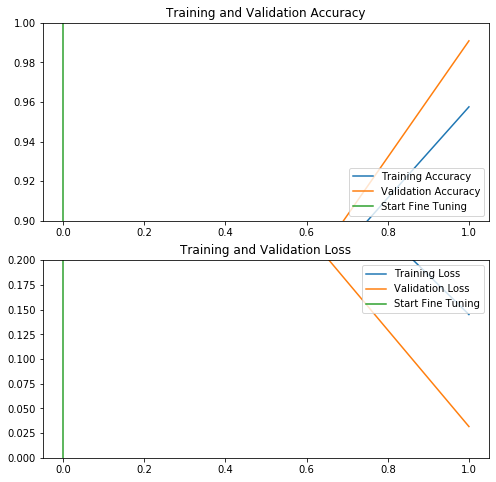

In [30]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.9, 1])
plt.plot([epochs-1,epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 0.2])
plt.plot([epochs-1,epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Оценим параметры модели.

In [31]:
# Calculating accuracy, precision, recall, f1 score.
def AccRecPrec(predictions, test_labels):

    x = tf.placeholder(tf.int32, )
    y = tf.placeholder(tf.int32, )
    acc, acc_op = tf.metrics.accuracy(labels=x, predictions=y)
    rec, rec_op = tf.metrics.recall(labels=x, predictions=y)
    pre, pre_op = tf.metrics.precision(labels=x, predictions=y)
    f1,  f1_op  = tf.contrib.metrics.f1_score(labels=x, predictions=y)

    def f(x):
        if (x>0.5):
            return 1
        else:
            return 0
        
    predictions = np.array(list(map(f, predictions)))

    sess=tf.Session()
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    v = sess.run(acc_op, feed_dict={x: test_labels,y: predictions}) # Accuracy.
    r = sess.run(rec_op, feed_dict={x: test_labels,y: predictions}) # Recall.
    p = sess.run(pre_op, feed_dict={x: test_labels,y: predictions}) # Precision.
    f = sess.run(f1_op,  feed_dict={x: test_labels,y: predictions}) # F1.

    print("accuracy: ", v)
    print("recall:   ", r)
    print("precision:", p)
    print("f1:       ", 2*p*r/(p+r))

In [67]:
test_datagen = ImageDataGenerator(rescale = 1/255)
test_generator = test_datagen.flow_from_directory(
        DATA_FOLDER + '/test1',
        target_size = (image_size, image_size),
        batch_size = batch_size,
        shuffle=False,
        class_mode = "binary"
)

Found 5 images belonging to 2 classes.


In [68]:
model.predict_generator(test_generator)

array([[0.90160346],
       [0.46170372],
       [0.61631936],
       [0.09416848],
       [0.6549401 ]], dtype=float32)

In [64]:
AccRecPrec(model.predict_generator(test_generator), test_generator.classes)

accuracy:  0.0
recall:    0.0
precision: 0.0
f1:        nan


C:\Users\intern\Anaconda3\envs\TensorFlowEnv\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars
